In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2,
    EfficientNetB3, EfficientNetB4, EfficientNetB5,
    EfficientNetB6, EfficientNetB7
)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score


In [9]:
# Set paths for your dataset
base_dir = r"C:\Users\HP\AppData\Local\Programs\Python\Python311\Scripts\Datasets\dataset"  # Updated to your dataset directory
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Define parameters
img_size = (224, 224)
batch_size = 8  # Adjust as needed

# Create ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}


Found 42 images belonging to 2 classes.
Found 42 images belonging to 2 classes.


In [10]:
def train_efficientnet(model_name, train_generator, validation_generator, class_weights_dict, epochs=10):
    # Load the appropriate EfficientNet variant
    if model_name == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB1':
        base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB2':
        base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB3':
        base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB4':
        base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB5':
        base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB6':
        base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_name == 'EfficientNetB7':
        base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Add top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze all layers for fine-tuning
    for layer in base_model.layers:
        layer.trainable = True

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        class_weight=class_weights_dict,
        callbacks=[early_stopping]
    )

    return history


In [6]:
# List of EfficientNet versions
model_names = ['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 
               'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7']

# Dictionary to store histories of each model
histories = {}

for model_name in model_names:
    print(f"Training {model_name}...")
    history = train_efficientnet(model_name, train_generator, validation_generator, class_weights_dict, epochs=10)
    histories[model_name] = history
    print(f"Finished training {model_name}.\n")


Training EfficientNetB0...
Epoch 1/10


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.5497 - loss: 0.9288 - val_accuracy: 0.0952 - val_loss: 0.7275
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6208 - loss: 0.8201 - val_accuracy: 0.0952 - val_loss: 0.7284
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5677 - loss: 0.5922 - val_accuracy: 0.0952 - val_loss: 0.7263
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6373 - loss: 0.6176 - val_accuracy: 0.0952 - val_loss: 0.7451
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6120 - loss: 0.6680 - val_accuracy: 0.0952 - val_loss: 0.7470
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6020 - loss: 0.6180 - val_accuracy: 0.0952 - val_loss: 0.7331
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5962 - loss: 0.6787 - val_accuracy: 0.0952 - val_loss: 0.7105
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5900 - loss: 0.5564 - val_accuracy: 0.1190 - val_loss: 0.6958
Epoch 9/10
6/6 ━━━━━━━━━━━

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 216s 8s/step - accuracy: 0.6757 - loss: 0.6650 - val_accuracy: 0.9048 - val_loss: 0.6433
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step - accuracy: 0.6023 - loss: 0.7004 - val_accuracy: 0.9048 - val_loss: 0.6290
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - accuracy: 0.6605 - loss: 0.6472 - val_accuracy: 0.9048 - val_loss: 0.6128
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.7115 - loss: 0.6853 - val_accuracy: 0.9048 - val_loss: 0.5961
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.6003 - loss: 0.6858 - val_accuracy: 0.9048 - val_loss: 0.5779
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.7496 - loss: 0.5613 - val_accuracy: 0.9048 - val_loss: 0.5606
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.7207 - loss: 0.7495 - val_accuracy: 0.9048 - val_loss: 0.5432
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.8037 - loss: 0.6144 - val_accuracy: 0.9048 - val_loss: 0.5225
Epoch 9

DecodeError: Error parsing message

AttributeError: 'dict' object has no attribute 'history'

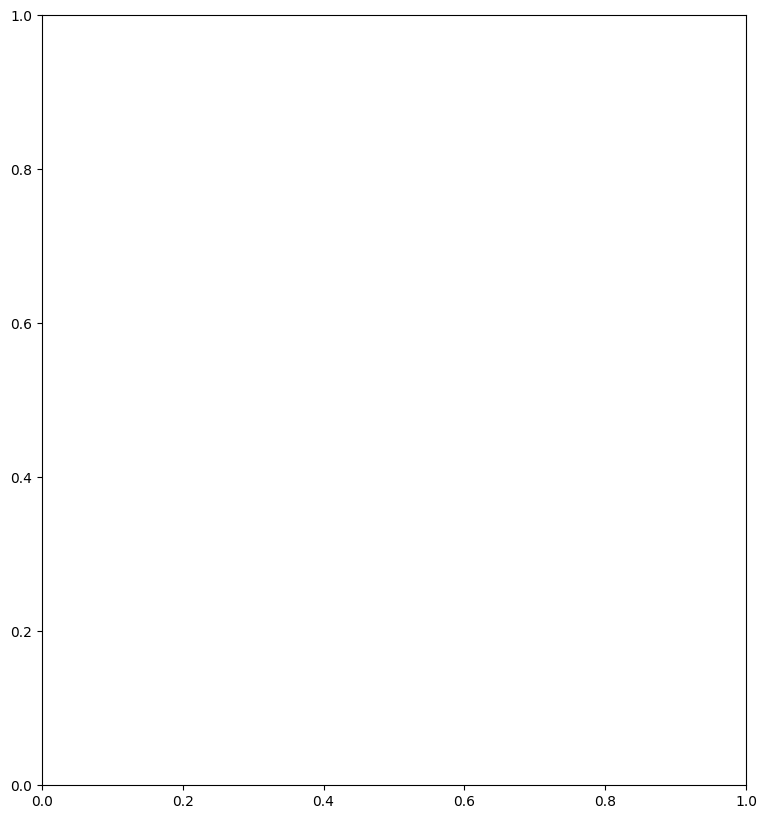

In [4]:
import matplotlib.pyplot as plt

# Assuming 'histories' is a dictionary containing training histories for all models
# Example: histories = {'EfficientNetB0': history_b0, 'EfficientNetB1': history_b1, ...}

# List of model names
model_names = ['EfficientNetB0','EfficientNetB1','EfficientNetB2','EfficientNetB3','EfficientNetB4', 'EfficientNetB5', 
               'EfficientNetB6']

# Plotting accuracy and loss for all models
plt.figure(figsize=(20, 10))

# Accuracy plots
plt.subplot(1, 2, 1)
for model_name in model_names:
    plt.plot(histories[model_name].history['accuracy'], label=f'{model_name} Train')
    plt.plot(histories[model_name].history['val_accuracy'], label=f'{model_name} Validation', linestyle='--')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plots
plt.subplot(1, 2, 2)
for model_name in model_names:
    plt.plot(histories[model_name].history['loss'], label=f'{model_name} Train')
    plt.plot(histories[model_name].history['val_loss'], label=f'{model_name} Validation', linestyle='--')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [3]:
# Manually reconstructed histories for EfficientNet B0 to B6
histories = {
    'EfficientNetB0': {
        'accuracy': [0.5497, 0.6208, 0.5677, 0.6373, 0.6120, 0.6020, 0.5962, 0.5900, 0.6961, 0.7306],
        'val_accuracy': [0.0952, 0.0952, 0.0952, 0.0952, 0.0952, 0.0952, 0.0952, 0.1190, 0.9048, 0.9048],
        'loss': [0.9288, 0.8201, 0.5922, 0.6176, 0.6680, 0.6180, 0.6787, 0.5564, 0.8876, 0.6106],
        'val_loss': [0.7275, 0.7284, 0.7263, 0.7451, 0.7470, 0.7331, 0.7105, 0.6958, 0.6850, 0.6798],
    },
    'EfficientNetB1': {
        'accuracy': [0.2900, 0.2558, 0.3275, 0.3380, 0.3397, 0.3646, 0.4718, 0.3534, 0.4628, 0.4369],
        'val_accuracy': [0.0952] * 10,
        'loss': [0.7101, 0.6702, 0.5446, 0.5556, 0.5731, 0.5951, 0.6155, 0.5684, 0.5232, 0.5028],
        'val_loss': [0.7216, 0.7189, 0.7169, 0.7137, 0.7113, 0.7089, 0.7079, 0.7073, 0.7067, 0.7067],
    },
    'EfficientNetB2': {
        'accuracy': [0.8911, 0.7974, 0.9835, 0.9154, 0.9214, 0.9767, 0.9398, 0.8625, 0.9287, 0.9333],
        'val_accuracy': [0.0952, 0.0952, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048, 0.9048],
        'loss': [0.7353, 0.5633, 0.4500, 0.5268, 0.6811, 0.4581, 0.4528, 0.5877, 0.4997, 0.7725],
        'val_loss': [0.7235, 0.7033, 0.6787, 0.6477, 0.6046, 0.5787, 0.5563, 0.5386, 0.5240, 0.5177],
    },
    'EfficientNetB3': {
        'accuracy': [0.2691, 0.2695, 0.3779, 0.4938, 0.4165, 0.5866, 0.4338, 0.5179, 0.4931, 0.5460],
        'val_accuracy': [0.0952] * 10,
        'loss': [0.6417, 0.6206, 0.6241, 0.7731, 0.6178, 0.6545, 0.7138, 0.7387, 0.6342, 0.5544],
        'val_loss': [0.7667, 0.7860, 0.8053, 0.8322, 0.8674, 0.8936, 0.9109, 0.9173, 0.9173, 0.9092],
    },
    'EfficientNetB4': {
        'accuracy': [0.2887, 0.2103, 0.4453, 0.3839, 0.4400, 0.4936, 0.5034, 0.4919, 0.4372, 0.6249],
        'val_accuracy': [0.0952] * 9 + [0.8810],
        'loss': [0.6572, 0.7126, 0.6685, 0.5365, 0.5993, 0.6043, 0.6348, 0.7913, 0.5172, 0.5426],
        'val_loss': [0.7801, 0.7904, 0.7893, 0.7834, 0.7700, 0.7561, 0.7389, 0.7206, 0.7017, 0.6877],
    },
    'EfficientNetB5': {
        'accuracy': [0.6757, 0.6023, 0.6605, 0.7115, 0.6003, 0.7496, 0.7207, 0.8037, 0.6755, 0.6908],
        'val_accuracy': [0.9048] * 10,
        'loss': [0.6650, 0.7004, 0.6472, 0.6853, 0.6858, 0.5613, 0.7495, 0.6144, 0.7509, 0.7819],
        'val_loss': [0.6433, 0.6290, 0.6128, 0.5961, 0.5779, 0.5606, 0.5432, 0.5225, 0.5037, 0.4832],
    },
    'EfficientNetB6': {
        'accuracy': [0.2157, 0.2096, 0.3282, 0.2492, 0.2398, 0.3443, 0.2601, 0.3178, 0.3686, 0.3709],
        'val_accuracy': [0.0952] * 10,
        'loss': [0.7623, 0.6175, 0.5531, 0.6416, 1.0233, 0.5779, 0.6985, 0.5315, 0.7450, 0.6466],
        'val_loss': [0.9217, 0.9216, 0.9239, 0.9320, 0.9372, 0.9413, 0.9526, 0.9635, 0.9694, 0.9700],
    },
}


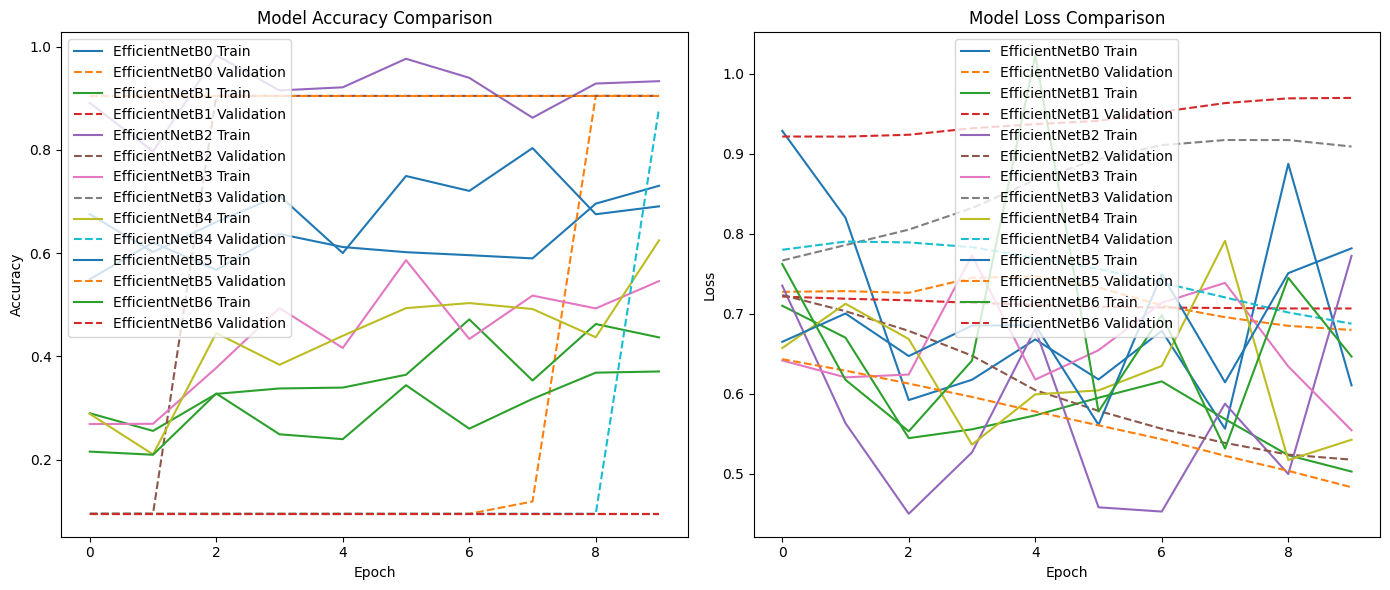

In [6]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    plt.figure(figsize=(14, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{model_name} Train')
        plt.plot(history['val_accuracy'], label=f'{model_name} Validation', linestyle='dashed')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history['loss'], label=f'{model_name} Train')
        plt.plot(history['val_loss'], label=f'{model_name} Validation', linestyle='dashed')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_histories(histories)


In [11]:
# Train EfficientNetB7 and store its history
print("Training EfficientNetB7...")
history_b7 = train_efficientnet('EfficientNetB7', train_generator, validation_generator, class_weights_dict, epochs=10)

# Add history of EfficientNetB7 to the histories
histories['EfficientNetB7'] = {
    'accuracy': history_b7.history['accuracy'],
    'val_accuracy': history_b7.history['val_accuracy'],
    'loss': history_b7.history['loss'],
    'val_loss': history_b7.history['val_loss'],
}

print("Finished training EfficientNetB7.")


Training EfficientNetB7...
Epoch 1/10


C:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 219s 16s/step - accuracy: 0.5598 - loss: 0.5979 - val_accuracy: 0.9048 - val_loss: 0.6684
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 74s 11s/step - accuracy: 0.5177 - loss: 0.6109 - val_accuracy: 0.9048 - val_loss: 0.6471
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.5541 - loss: 0.6980 - val_accuracy: 0.9048 - val_loss: 0.6283
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 69s 11s/step - accuracy: 0.5415 - loss: 0.6535 - val_accuracy: 0.9048 - val_loss: 0.6066
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 11s/step - accuracy: 0.6437 - loss: 0.5734 - val_accuracy: 0.9048 - val_loss: 0.5848
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 16s/step - accuracy: 0.7470 - loss: 0.6196 - val_accuracy: 0.9048 - val_loss: 0.5658
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.5014 - loss: 0.4975 - val_accuracy: 0.9048 - val_loss: 0.5471
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 91s 16s/step - accuracy: 0.6964 - loss: 0.6121 - val_accuracy: 0.9048 - val_loss: 0.5311
Epoch 9/10

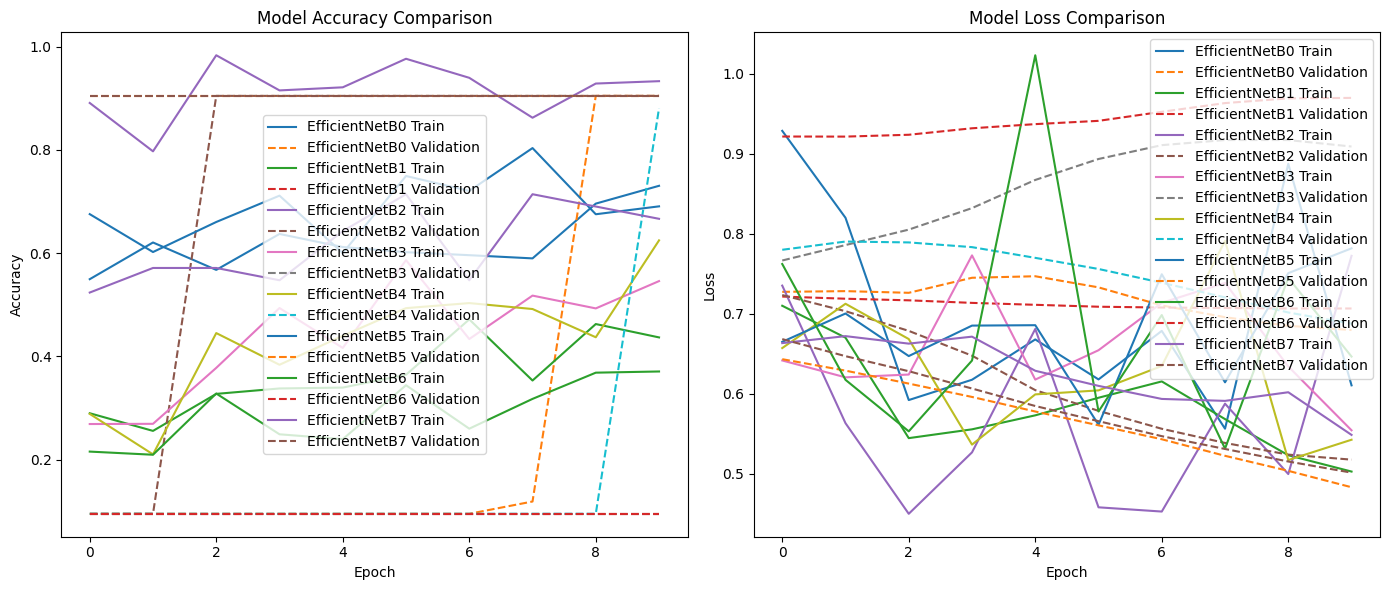

In [12]:
import matplotlib.pyplot as plt

def plot_histories(histories):
    plt.figure(figsize=(14, 6))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{model_name} Train')
        plt.plot(history['val_accuracy'], label=f'{model_name} Validation', linestyle='dashed')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history['loss'], label=f'{model_name} Train')
        plt.plot(history['val_loss'], label=f'{model_name} Validation', linestyle='dashed')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_histories(histories)


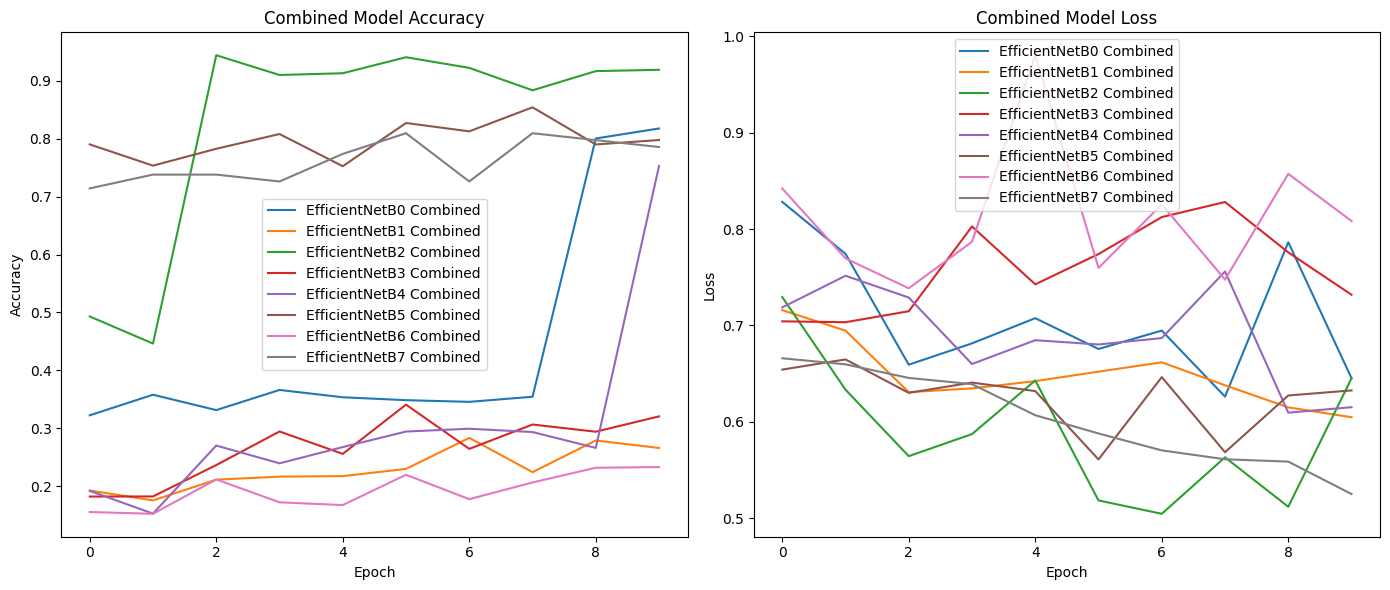

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_combined_histories(histories):
    plt.figure(figsize=(14, 6))

    # Combined Accuracy Plot
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        # Average training and validation accuracy
        avg_accuracy = np.mean([history['accuracy'], history['val_accuracy']], axis=0)
        plt.plot(avg_accuracy, label=f'{model_name} Combined')
    plt.title('Combined Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Combined Loss Plot
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        # Average training and validation loss
        avg_loss = np.mean([history['loss'], history['val_loss']], axis=0)
        plt.plot(avg_loss, label=f'{model_name} Combined')
    plt.title('Combined Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the updated plotting function
plot_combined_histories(histories)
